# Hyperparameter Tuning Methods Comparison
Cross validation approach based on the following [repo](https://github.com/roamanalytics/roamresearch/tree/master/BlogPosts/Hyperparameter_tuning_comparison)

In [24]:
%matplotlib inline

In [25]:
import dataset_loader as datasets
import seaborn as sns
from hpt_cmp import *
from model_loader import *

In [26]:
%load_ext autoreload
%aimport hpt_cmp
%aimport dataset_loader
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from __future__ import print_function
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from hyperopt import 

In [28]:
# Loading the Digits dataset
mth = 'load_'+'digits'
digits = datasets.load_digits()
iris = datasets.load_iris()
wine = datasets.load_wine()
bc = datasets.load_breast_cancer()
cs = datasets.load_census_50k()

dataset = digits
# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_features = dataset.data.shape[1]


In [54]:
# x = 1
# while x < n_features:
#     max_f.append(x)
#     x +=x
# max_f.append(n_features)

In [61]:
max_f = ['auto', 'sqrt', 'log2']
seed = np.array([1], dtype=np.integer)
n_features = dataset.data.shape[1]
param_grid = {
        "max_depth": [3, None],
        "max_features": max_f,
        #"min_samples_split": [5, 10, 20],
        #"bootstrap": [True, False],
        "criterion": ["gini", "entropy"],
        'random_state':seed[0]
}

hyperopt_grid = {
        "max_depth": hp.choice("max_depth",[3, None]),
        "max_features": hp.choice("max_features",max_f),
        #"min_samples_split": hp.loguniform("min_samples_split",np.log(5), np.log(20)),
        #"bootstrap": hp.choice("bootstrap",[True, False]),
        "criterion": hp.choice("criterion",["gini", "entropy"]),
        'random_state':seed
}

bayes_grid = {
        "max_depth": Categorical([3, None]),
        "max_features": Categorical(max_f),
        #"min_samples_split": Real(5, 20, 'loguniform'),
        #"bootstrap": Categorical([True, False]),
        "criterion": Categorical(["gini", "entropy"]),
        'random_state':seed
}

base = {
    'random_state':seed[0]
}

In [62]:
hpt_objs = [
    # add more objs once more search functions implemented
        ('Baseline', base, run_baseline, {}),
        ('BaysianSearch', bayes_grid,baysian_search,{'n_iter':MAX_ITER}),
        ('Tree of Parzen Estimator',hyperopt_grid,tpe_search,{}),
        ('RandomSearch', param_grid, random_search,{'n_iter':MAX_ITER}),
        ('GridSearch', param_grid, grid_search, {}),
]

#### cmp_hpt_methods
Parameter description
> `htp_objs`: list of hyperparam-tuning object <br>
> `model`: sklearn model to optimize (needs to have fit/predict function)<br>
> `dataset`: tuple of (X,y) e.g (Data, Target) <br>
> `loss`: sklearn loss function to user <br>
> `metric`: sklearn metric to optimize for <br>
> `datset_split`: random_state for datasetsplit <br>
> `name`: currently not user *optional* <br>

In [63]:
all_results = []

# Run search & print result
results = cmp_hpt_methods(
        (dataset.data, dataset.target),
        hpt_objs,
        RandomForestClassifier,
        'accuracy', #http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        accuracy_score, name='RandFor-digits')
all_results.append(results)

25 3


/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: 'gini'

In [ ]:
sum_res = []
for r in all_results[0]:
    sum_res.append((r[HPT_METHOD], r[CV_TIME],len(r[INNER_RES]['params']), r[TEST_ACC], r[BEST_PARAMS], np.array(r[INNER_RES]['mean_test_score']).mean() ))

df = pd.DataFrame(sum_res, columns=[HPT_METHOD, 'TIME', PARAMS_SAMPLED, TEST_ACC, BEST_PARAMS, 'SCORE'])

In [31]:
df

NameError: name 'df' is not defined

In [32]:
pd.DataFrame(df[BEST_PARAMS].tolist())

NameError: name 'df' is not defined

In [33]:
# plot comparison
plt.figure()
sns.barplot(x='TIME', y=HPT_METHOD,data =df, color='b')
plt.figure()
# plot accuracy comparison
fig, ax =plt.subplots()
ax.set(xlim=(0.95, 1.0))
sns.barplot(x=TEST_ACC, y=HPT_METHOD, ax = ax,data =df, color='b')

NameError: name 'df' is not defined

<Figure size 432x288 with 0 Axes>

In [34]:
for r in all_results[0]:
    plot_confusion_matrix(r[CONF_MATRIX], digits.target_names)

NameError: name 'all_results' is not defined

NameError: name 'all_results' is not defined

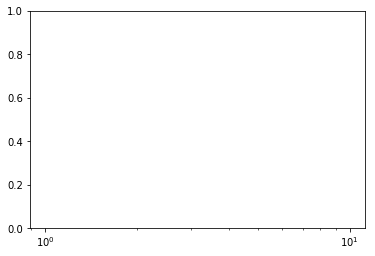

In [35]:
for param in ['C', 'gamma']:
    fig, ax = plt.subplots()
    ax.set_xscale('log')
    for r in all_results[0]:

        if r[HPT_METHOD]=='Baseline': continue
        ax = sns.lineplot(x='param_'+param, y='mean_test_score', data=r[INNER_RES], label=r[HPT_METHOD])
        ax.set_title(param)

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
for r in all_results[0]:
    sns.lineplot(x=[i for i in range(r[PARAMS_SAMPLED])], y=r[INNER_RES]['mean_test_score'],label=r[HPT_METHOD])